In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
sys.path.insert(0, '../')
from height_model_scripts.loss_functions import rmse, weighted_rmse
from height_model_scripts.metrics import F1_metric, RMSE, MAE, R2, MBE
from height_model_scripts.height_model_scripts import Generator
from height_model_scripts.save_pred import save_pred, tif2geojson

### Split on test, train, validation

In [4]:
train_img_list = []
test_img_list = []
val_img_list = []

train_list_split = ['0_0', '0_1', '0_2',
               '1_0', '1_2',
               '2_0', '2_1', '2_3', '2_4', '2_5',
               '3_1', '3_2', '3_3',
               '4_1', '4_3', '4_4', '4_5',
               '5_1', '5_2', '5_3', '5_4',
               '6_0', '6_1', '6_2', '6_4',
               '7_0', '7_1', '7_2', '7_3', '7_4']
val_list_split = ['1_1', '2_2', '4_2', '6_3']

# krasnoborsk
for folder in os.listdir('/home/user/data/krasnoborsk/world_view/'):
    if 'tif' in folder or 'xml' in folder or folder == 'lines':
        continue
    for file_name in os.listdir('/home/user/data/krasnoborsk/world_view/{}'.format(folder)):
        tmp_ind = file_name.split('_')[0]+'_'+file_name.split('_')[1]
        if tmp_ind in train_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in train_img_list:
            train_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]
        elif tmp_ind in val_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in val_img_list \
            and folder == '0':
            val_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]

# Novoshinsk
dse_pathechs = ['0_0', '0_1', '0_2',
               '1_0', '1_1', '1_2', '1_3',
               '2_0', '2_1', '2_2', '2_3', '2_4', 
               '3_0', '3_1', '3_2', '3_3', '3_4',
               '4_0', '4_1', '4_3', '4_4',
               '5_3', '5_4',
               '6_2', '6_3', '6_4',
               '7_2', '7_3', '7_4',
               '8_2', '8_3', '8_4']

for file_ind in [0, 1, 7, 9]: 
    for patch_ind in dse_pathechs:
        i, j = patch_ind.split('_')
        if patch_ind +'_channel_0.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)) \
            or patch_ind +'_class_606.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)):
            continue
        if patch_ind in ['1_1', '2_2', '4_4']:
            test_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]
        else:
            train_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]


In [15]:
distribution = np.zeros(30)
for imgpath in train_img_list:
    tmp = tiff.imread(imgpath[:-3] + 'height_' + imgpath.split('/')[-1] +'.tif')
    tmp = tmp.clip(0, 30)
    distribution[0] += np.sum((tmp>0)*(tmp<0.5))
    for i in range(1, 30):
        distribution[i] += np.sum((tmp>=i-0.5)*(tmp<i+0.5))
    distribution[29] += np.sum((tmp>=29.5))
    

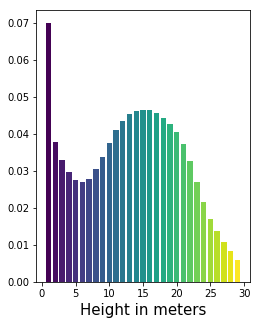

In [14]:
names = np.array([i for i in range(1, 30)])
values = (distribution / np.sum(distribution))[1:30]

from matplotlib import cm
viridis = cm.get_cmap('viridis', 29)

plt.figure(figsize=(13, 5))

plt.subplot(131)
plt.bar(names, values, color=viridis(range(29)))
#plt.suptitle('Categorical Plotting')
plt.xlabel('Height in meters', fontsize=15)
plt.show()

## New model

In [16]:
batch_size=20 
num_channels=5

gdal_file_path = './'

generator = Generator(train_img_list, val_img_list, batch_size, num_channels, gdal_file_path=gdal_file_path)

generator.augm = False              # just geometric rotation is applied
generator.color_aug_prob = 1       # add color augm

generator.sharpen_flag = True     # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided
generator.arctic_dem = True
generator.arctic_stat = {'min':125, 'max':250}

generator.lidar_coef = 5           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 1    # target resolution both for height and imagery
generator.clip_value = 30.         # the greatest height value 

generator.classifier_mode = 'regression'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif', 'channel_3.tif']

In [6]:
generator.write_gdalinfo_file()

## Save generator parametrs

In [7]:
generator_state = copy.deepcopy(generator.__dict__)
del generator_state['data_gdal']
del generator_state['img_prob']

save_file = 'regr_rgb_pan_nir_wv_arctic.json'
with open(save_file, 'w') as f:
    json.dump(generator_state, f)

## Check outputs

Text(0.5,1,'lidar')

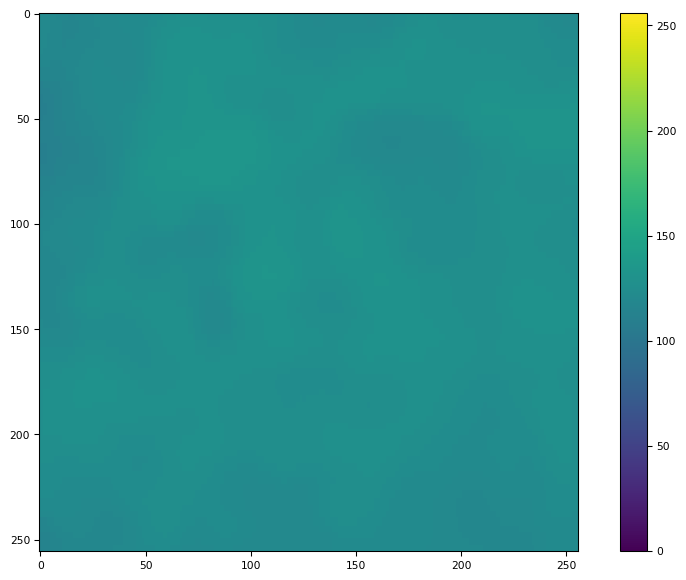

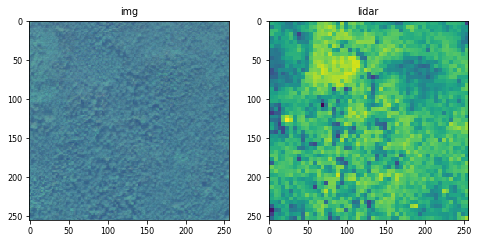

In [7]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'lidar')

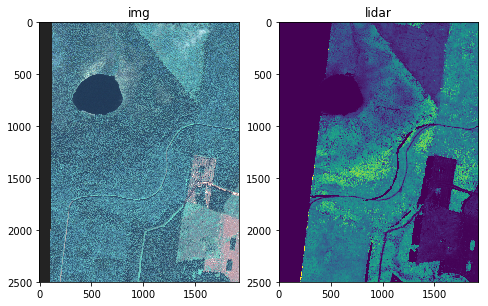

In [14]:
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[2])
generator.full_img = False  

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

## Set model

In [17]:
values=(0.5 /(distribution / np.max(distribution))[1:30]).clip(1, 4)

In [20]:
values

array([1.        , 1.        , 1.06632113, 1.17921519, 1.26985048,
       1.3016335 , 1.25381449, 1.15252443, 1.03586125, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.07301106, 1.29921649, 1.63052944, 2.05098494,
       2.55991671, 3.23030735, 4.        , 2.70457008])

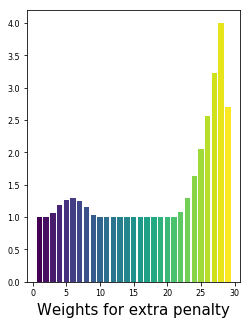

In [45]:
names = np.array([i for i in range(1, 30)])
#values = (distribution / np.sum(distribution))[1:30]

from matplotlib import cm
viridis = cm.get_cmap('viridis', 29)

plt.figure(figsize=(13, 5))

plt.subplot(131)
plt.bar(names, values, color=viridis(range(29)))
#plt.suptitle('Categorical Plotting')
plt.xlabel('Weights for extra penalty', fontsize=15)
plt.show()

In [19]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), 
                  encoder_weights=None, activation='sigmoid')
loss =  weighted_rmse(values)
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

/opt/conda/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.
  str(input_shape[-1]) + ' input channels.')


In [21]:
model_name = 'regr_rgb_pan_nir_wv_arctic_weighted'
save_dir = '/home/user/data/example/data/Forestry_inventory/Height_model_paper/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=4,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [22]:
history=model.fit_generator(generator.train_gen(),epochs=23, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/23
200/200 [==============================] - 196s 979ms/step - loss: 0.2876 - loss_1: 0.2876 - val_loss: 0.6906 - val_loss_1: 0.6906

Epoch 00001: val_loss improved from inf to 0.69058, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.h5

Epoch 00001: val_loss improved from inf to 0.69058, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.hdf5
Epoch 2/23
200/200 [==============================] - 147s 737ms/step - loss: 0.2543 - loss_1: 0.2543 - val_loss: 0.2635 - val_loss_1: 0.2635

Epoch 00002: val_loss improved from 0.69058 to 0.26345, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.h5

Epoch 00002: val_loss improved from 0.69058 to 0.26345, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.hdf5
Epoc

Epoch 23/23
200/200 [==============================] - 145s 727ms/step - loss: 0.1645 - loss_1: 0.1645 - val_loss: 0.1584 - val_loss_1: 0.1584

Epoch 00023: val_loss improved from 0.15880 to 0.15841, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.h5

Epoch 00023: val_loss improved from 0.15880 to 0.15841, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.hdf5


In [47]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [50]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

## Evaluation

In [25]:
prediction, full_mask = generator.pred_img(model=model, img_path=val_img_list[2])

Text(0.5,1,'lidar')

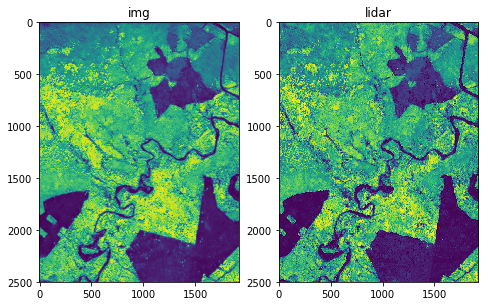

In [26]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((prediction[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow((full_mask[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('lidar')

In [281]:
generator.full_img=True
img, _ = generator.get_img_mask_array(val_img_list[2])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0e04d8d940>)

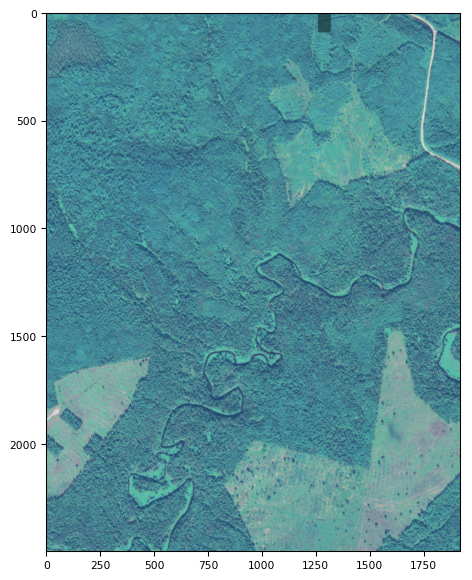

In [287]:
tiff.imshow(img[:,:,:3])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0e04d004e0>)

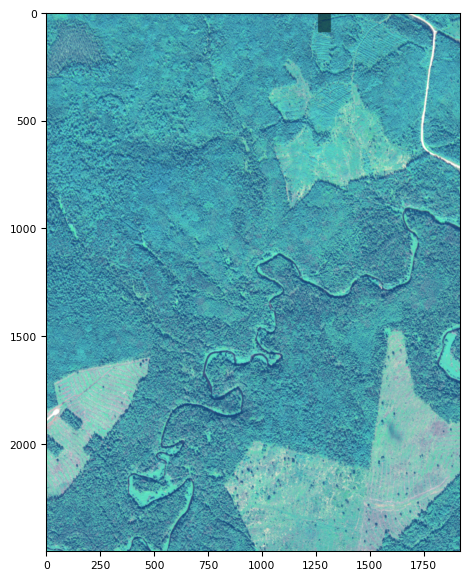

In [286]:
tiff.imshow((img[:,:,:3]-np.min(img[:,:,:3]))/(np.max(img[:,:,:3]) - np.min(img[:,:,:3])))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f74d96c6da0>)

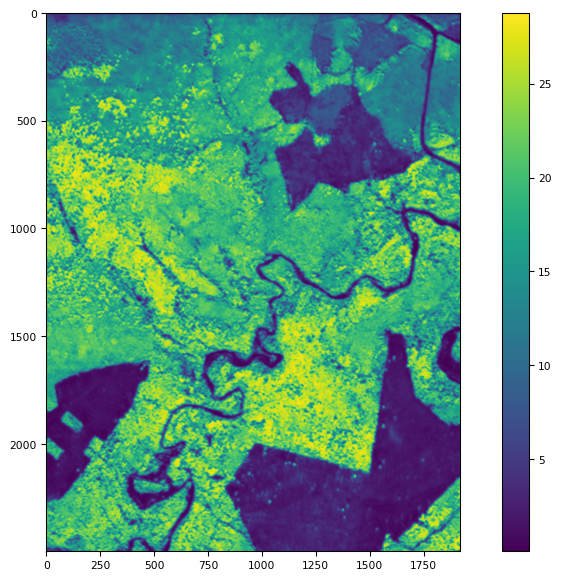

In [27]:
tiff.imshow(prediction*generator.clip_value)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f74cd9eaf98>)

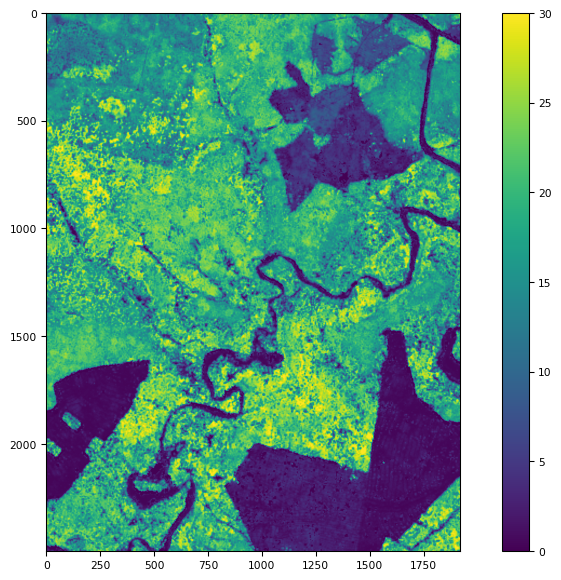

In [28]:
tiff.imshow(full_mask*generator.clip_value)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f74c4b4b2b0>)

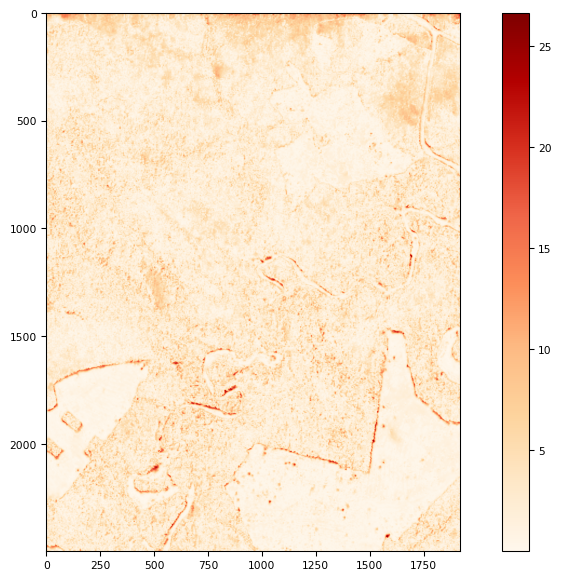

In [29]:
tiff.imshow(np.abs(prediction-full_mask)*generator.clip_value, cmap='OrRd')

In [30]:
print('RMSE', RMSE(prediction*generator.clip_value, full_mask*generator.clip_value))
print('MAE', MAE(prediction*generator.clip_value, full_mask*generator.clip_value))

RMSE 3.886
MAE 2.767


In [23]:
generator.augm  = False
average_rmse = 0
average_mae = 0
average_r2 = 0
average_mean_bias = 0
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    cur_rmse = RMSE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mae = MAE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_r2 = R2(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mean_bias = MBE(prediction*generator.clip_value, full_mask*generator.clip_value)
    average_rmse += cur_rmse
    average_mae += cur_mae
    average_r2 += cur_r2
    average_mean_bias += cur_mean_bias
    print(ind, 'rmse: ', cur_rmse, ' mae: ', cur_mae,  ' r2: ', cur_r2,  ' mbe: ', cur_mean_bias, )

print('~~~~~~~~~~~~~~~~')
print('Average RMSE: ', round(average_rmse / len(val_img_list), 3))
print('Average MAE: ', round(average_mae / len(val_img_list), 3))
print('Average R2: ', round(average_r2 / len(val_img_list), 3))
print('Average mean bias: ', round(average_mean_bias / len(val_img_list), 3))

0 rmse:  4.453  mae:  2.622  r2:  0.594  mbe:  0.12740792410438478
1 rmse:  2.714  mae:  1.946  r2:  0.778  mbe:  -0.0995288770665231
2 rmse:  3.886  mae:  2.767  r2:  0.787  mbe:  -0.23000857456547855
3 rmse:  3.536  mae:  2.547  r2:  0.598  mbe:  -0.9014157224151399
~~~~~~~~~~~~~~~~
Average RMSE:  3.647
Average MAE:  2.47
Average R2:  0.689
Average mean bias:  -0.276


In [51]:
generator.augm  = False
average_rmse = 0
average_mae = 0
average_r2 = 0
average_mean_bias = 0
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    cur_rmse = RMSE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mae = MAE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_r2 = R2(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mean_bias = MBE(prediction*generator.clip_value, full_mask*generator.clip_value)
    average_rmse += cur_rmse
    average_mae += cur_mae
    average_r2 += cur_r2
    average_mean_bias += cur_mean_bias
    print(ind, 'rmse: ', cur_rmse, ' mae: ', cur_mae,  ' r2: ', cur_r2,  ' mbe: ', cur_mean_bias, )

print('~~~~~~~~~~~~~~~~')
print('Average RMSE: ', round(average_rmse / len(val_img_list), 3))
print('Average MAE: ', round(average_mae / len(val_img_list), 3))
print('Average R2: ', round(average_r2 / len(val_img_list), 3))
print('Average mean bias: ', round(average_mean_bias / len(val_img_list), 3))

0 rmse:  4.423  mae:  2.662  r2:  0.599  mbe:  0.3571494636184732
1 rmse:  2.703  mae:  1.959  r2:  0.78  mbe:  0.23154950571944938
2 rmse:  3.789  mae:  2.715  r2:  0.798  mbe:  0.20666881268548198
3 rmse:  3.514  mae:  2.526  r2:  0.603  mbe:  -0.7003137241232229
~~~~~~~~~~~~~~~~
Average RMSE:  3.607
Average MAE:  2.466
Average R2:  0.695
Average mean bias:  0.024


In [35]:
num_cl = 4
generator.augm = False
F1_score = np.zeros((num_cl))
class_names=['0-4', '4-10', '10-20', '>20']
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    
    prediction *= generator.clip_value
    full_mask *= generator.clip_value

    pred = np.zeros((1, prediction.shape[0], prediction.shape[1], num_cl))
    mask = np.zeros((1, full_mask.shape[0], full_mask.shape[1], num_cl)) 

    pred[:,:,:,0] = np.where(prediction[:,:,0]>0, 1, 0) * np.where(prediction[:,:,0]<4, 1, 0)
    mask[:,:,:,0] = np.where(full_mask[:,:,0]>0, 1, 0) * np.where(full_mask[:,:,0]<4, 1, 0)

    pred[:,:,:,1] = np.where(prediction[:,:,0]>=4, 1, 0) * np.where(prediction[:,:,0]<10, 1, 0)
    mask[:,:,:,1] = np.where(full_mask[:,:,0]>=4, 1, 0) * np.where(full_mask[:,:,0]<10, 1, 0)

    pred[:,:,:,2] = np.where(prediction[:,:,0]>=10, 1, 0) * np.where(prediction[:,:,0]<20, 1, 0)
    mask[:,:,:,2] = np.where(full_mask[:,:,0]>=10, 1, 0) * np.where(full_mask[:,:,0]<20, 1, 0)

    pred[:,:,:,3] = np.where(prediction[:,:,0]>=20, 1, 0)
    mask[:,:,:,3] = np.where(full_mask[:,:,0]>=20, 1, 0)

    F1_score += F1_metric(pred, mask, num_cl = num_cl, class_names=[])
    

0 : precision  0.892  recall  0.611  f1  0.725
 
1 : precision  0.647  recall  0.708  f1  0.676
 
2 : precision  0.821  recall  0.946  f1  0.879
 
3 : precision  0.744  recall  0.447  f1  0.558
 
0 : precision  0.913  recall  0.742  f1  0.819
 
1 : precision  0.64  recall  0.669  f1  0.654
 
2 : precision  0.851  recall  0.925  f1  0.887
 
3 : precision  0.696  recall  0.267  f1  0.386
 
0 : precision  0.909  recall  0.872  f1  0.89
 
1 : precision  0.51  recall  0.463  f1  0.485
 
2 : precision  0.693  recall  0.744  f1  0.718
 
3 : precision  0.733  recall  0.702  f1  0.717
 
0 : precision  0.895  recall  0.63  f1  0.74
 
1 : precision  0.409  recall  0.147  f1  0.217
 
2 : precision  0.847  recall  0.872  f1  0.859
 
3 : precision  0.712  recall  0.731  f1  0.721
 


In [36]:
print(F1_score / len(val_img_list))
print(np.sum(F1_score / len(val_img_list))/num_cl)

[0.79337054 0.50806577 0.83573816 0.59572692]
0.6832253470011631


In [52]:
num_cl = 4
generator.augm = False
F1_score = np.zeros((num_cl))
class_names=['0-4', '4-10', '10-20', '>20']
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    
    prediction *= generator.clip_value
    full_mask *= generator.clip_value

    pred = np.zeros((1, prediction.shape[0], prediction.shape[1], num_cl))
    mask = np.zeros((1, full_mask.shape[0], full_mask.shape[1], num_cl)) 

    pred[:,:,:,0] = np.where(prediction[:,:,0]>0, 1, 0) * np.where(prediction[:,:,0]<4, 1, 0)
    mask[:,:,:,0] = np.where(full_mask[:,:,0]>0, 1, 0) * np.where(full_mask[:,:,0]<4, 1, 0)

    pred[:,:,:,1] = np.where(prediction[:,:,0]>=4, 1, 0) * np.where(prediction[:,:,0]<10, 1, 0)
    mask[:,:,:,1] = np.where(full_mask[:,:,0]>=4, 1, 0) * np.where(full_mask[:,:,0]<10, 1, 0)

    pred[:,:,:,2] = np.where(prediction[:,:,0]>=10, 1, 0) * np.where(prediction[:,:,0]<20, 1, 0)
    mask[:,:,:,2] = np.where(full_mask[:,:,0]>=10, 1, 0) * np.where(full_mask[:,:,0]<20, 1, 0)

    pred[:,:,:,3] = np.where(prediction[:,:,0]>=20, 1, 0)
    mask[:,:,:,3] = np.where(full_mask[:,:,0]>=20, 1, 0)

    F1_score += F1_metric(pred, mask, num_cl = num_cl, class_names=[])
    

0 : precision  0.867  recall  0.639  f1  0.736
 
1 : precision  0.643  recall  0.7  f1  0.671
 
2 : precision  0.812  recall  0.946  f1  0.874
 
3 : precision  0.761  recall  0.39  f1  0.516
 
0 : precision  0.9  recall  0.765  f1  0.827
 
1 : precision  0.631  recall  0.694  f1  0.661
 
2 : precision  0.85  recall  0.922  f1  0.885
 
3 : precision  0.754  recall  0.198  f1  0.314
 
0 : precision  0.9  recall  0.883  f1  0.891
 
1 : precision  0.506  recall  0.467  f1  0.486
 
2 : precision  0.681  recall  0.79  f1  0.731
 
3 : precision  0.774  recall  0.643  f1  0.703
 
0 : precision  0.894  recall  0.624  f1  0.735
 
1 : precision  0.379  recall  0.158  f1  0.223
 
2 : precision  0.838  recall  0.889  f1  0.863
 
3 : precision  0.736  recall  0.696  f1  0.715
 


In [53]:
print(F1_score / len(val_img_list))
print(np.sum(F1_score / len(val_img_list))/num_cl)

[0.79719867 0.51023488 0.83803107 0.56175516]
0.6768049455140943


In [46]:
(0.79+0.51+0.84+0.6)/4

0.685

In [37]:
num_cl = 4
F1_score = np.zeros((num_cl))
class_names=['0-4', '4-10', '10-20', '>20']
for ind, img_path in enumerate(train_img_list[8:]):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    
    prediction *= generator.clip_value
    full_mask *= generator.clip_value

    pred = np.zeros((1, prediction.shape[0], prediction.shape[1], num_cl))
    mask = np.zeros((1, full_mask.shape[0], full_mask.shape[1], num_cl)) 

    pred[:,:,:,0] = np.where(prediction[:,:,0]>0, 1, 0) * np.where(prediction[:,:,0]<4, 1, 0)
    mask[:,:,:,0] = np.where(full_mask[:,:,0]>0, 1, 0) * np.where(full_mask[:,:,0]<4, 1, 0)

    pred[:,:,:,1] = np.where(prediction[:,:,0]>=4, 1, 0) * np.where(prediction[:,:,0]<10, 1, 0)
    mask[:,:,:,1] = np.where(full_mask[:,:,0]>=4, 1, 0) * np.where(full_mask[:,:,0]<10, 1, 0)

    pred[:,:,:,2] = np.where(prediction[:,:,0]>=10, 1, 0) * np.where(prediction[:,:,0]<20, 1, 0)
    mask[:,:,:,2] = np.where(full_mask[:,:,0]>=10, 1, 0) * np.where(full_mask[:,:,0]<20, 1, 0)

    pred[:,:,:,3] = np.where(prediction[:,:,0]>=20, 1, 0)
    mask[:,:,:,3] = np.where(full_mask[:,:,0]>=20, 1, 0)

    F1_score += F1_metric(pred, mask, num_cl = num_cl, class_names=[])
    break

0 : precision  0.774  recall  0.844  f1  0.808
 
1 : precision  0.694  recall  0.707  f1  0.7
 
2 : precision  0.783  recall  0.77  f1  0.776
 
3 : precision  0.792  recall  0.768  f1  0.78
 


In [67]:
generator.full_img = True
img, _ = generator.get_img_mask_array(imgpath=img_path)
generator.full_img = False

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f108076f2e8>)

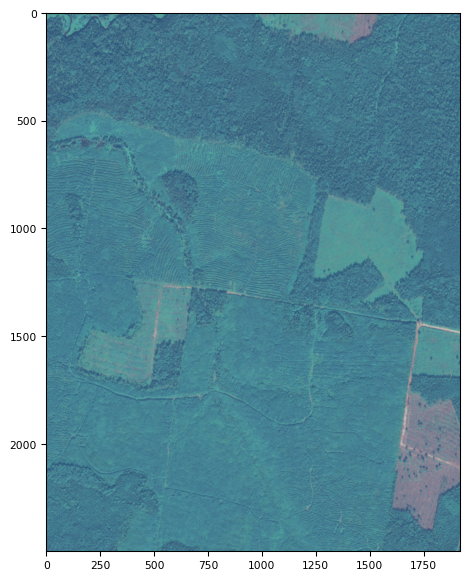

In [71]:
tiff.imshow(img[:,:,:3])

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 4)
print(viridis)

In [74]:
print('viridis(range(12))', viridis(range(4)))

viridis(range(12)) [[0.267004 0.004874 0.329415 1.      ]
 [0.190631 0.407061 0.556089 1.      ]
 [0.20803  0.718701 0.472873 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


In [76]:
mask[:,:,:,0].shape

(1, 2498, 1918)

In [77]:
cl_0 = np.asarray([mask[:,:,:,0], mask[:,:,:,0], mask[:,:,:,0]])

In [38]:
cl_0 = np.zeros((mask.shape[1], mask.shape[2], 3))

cl_0[:,:,0] = mask[:,:,:,0]*0.267004
cl_0[:,:,1] = mask[:,:,:,0]*0.004874
cl_0[:,:,2] = mask[:,:,:,0]*0.329415

cl_1 = np.zeros((mask.shape[1], mask.shape[2], 3))

cl_1[:,:,0] = mask[:,:,:,1]*0.190631
cl_1[:,:,1] = mask[:,:,:,1]* 0.407061
cl_1[:,:,2] = mask[:,:,:,1]* 0.556089

cl_2 = np.zeros((mask.shape[1], mask.shape[2], 3))

cl_2[:,:,0] = mask[:,:,:,2]*0.20803
cl_2[:,:,1] = mask[:,:,:,2]* 0.718701
cl_2[:,:,2] = mask[:,:,:,2]* 0.472873

cl_3 = np.zeros((mask.shape[1], mask.shape[2], 3))

cl_3[:,:,0] = mask[:,:,:,3]*0.993248
cl_3[:,:,1] = mask[:,:,:,3]* 0.906157
cl_3[:,:,2] = mask[:,:,:,3]* 0.143936

In [39]:
pr_0 = np.zeros((pred.shape[1], pred.shape[2], 3))

pr_0[:,:,0] = pred[:,:,:,0]*0.267004
pr_0[:,:,1] = pred[:,:,:,0]*0.004874
pr_0[:,:,2] = pred[:,:,:,0]*0.329415

pr_1 = np.zeros((pred.shape[1], pred.shape[2], 3))

pr_1[:,:,0] = pred[:,:,:,1]*0.190631
pr_1[:,:,1] = pred[:,:,:,1]* 0.407061
pr_1[:,:,2] = pred[:,:,:,1]* 0.556089

pr_2 = np.zeros((pred.shape[1], pred.shape[2], 3))

pr_2[:,:,0] = pred[:,:,:,2]*0.20803
pr_2[:,:,1] = pred[:,:,:,2]* 0.718701
pr_2[:,:,2] = pred[:,:,:,2]* 0.472873

pr_3 = np.zeros((pred.shape[1], pred.shape[2], 3))

pr_3[:,:,0] = pred[:,:,:,3]*0.993248
pr_3[:,:,1] = pred[:,:,:,3]* 0.906157
pr_3[:,:,2] = pred[:,:,:,3]* 0.143936

In [40]:
er_0 = np.zeros((mask.shape[1], mask.shape[2], 3))

er_0[:,:,0] = (np.array([mask[:,:,:,0]!= pred[:,:,:,0]]) + np.array([mask[:,:,:,1]!= pred[:,:,:,1]]) +\
              np.array([mask[:,:,:,2]!= pred[:,:,:,2]]) + np.array([mask[:,:,:,3]!= pred[:,:,:,3]]))*153
er_0[:,:,1] = (np.array([mask[:,:,:,0]!= pred[:,:,:,0]]) + np.array([mask[:,:,:,1]!= pred[:,:,:,1]]) +\
              np.array([mask[:,:,:,2]!= pred[:,:,:,2]]) + np.array([mask[:,:,:,3]!= pred[:,:,:,3]]))*0
er_0[:,:,2] = (np.array([mask[:,:,:,0]!= pred[:,:,:,0]]) + np.array([mask[:,:,:,1]!= pred[:,:,:,1]]) +\
              np.array([mask[:,:,:,2]!= pred[:,:,:,2]]) + np.array([mask[:,:,:,3]!= pred[:,:,:,3]]))*77

er_1 = np.zeros((mask.shape[1], mask.shape[2], 3))

er_1[:,:,0] = (np.array([mask[:,:,:,0]==pred[:,:,:,0]]) + np.array([mask[:,:,:,1]== pred[:,:,:,1]]) +\
              np.array([mask[:,:,:,2]== pred[:,:,:,2]]) + np.array([mask[:,:,:,3]== pred[:,:,:,3]]))*0.267004*255
er_1[:,:,1] = (np.array([mask[:,:,:,0]== pred[:,:,:,0]]) + np.array([mask[:,:,:,1]== pred[:,:,:,1]]) +\
              np.array([mask[:,:,:,2]== pred[:,:,:,2]]) + np.array([mask[:,:,:,3]== pred[:,:,:,3]]))*0.004874*255
er_1[:,:,2] = (np.array([mask[:,:,:,0]== pred[:,:,:,0]]) + np.array([mask[:,:,:,1]== pred[:,:,:,1]]) +\
              np.array([mask[:,:,:,2]== pred[:,:,:,2]]) + np.array([mask[:,:,:,3]== pred[:,:,:,3]]))*0.329415*255

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f74b1bbf908>)

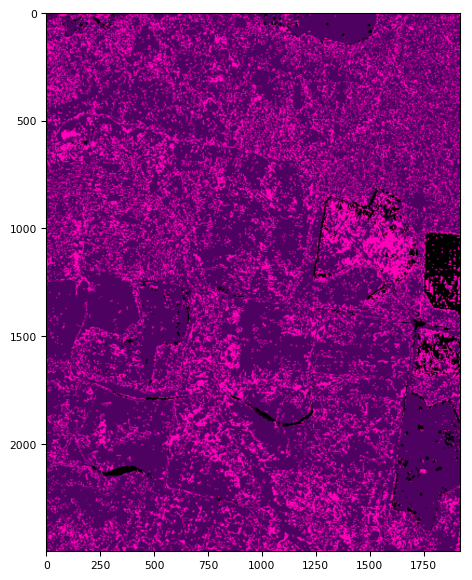

In [41]:
tiff.imshow((er_0 + er_1)*np.where(cl_0 + cl_1+cl_2+cl_3!=0, 1, 0))

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f750d728b00>)

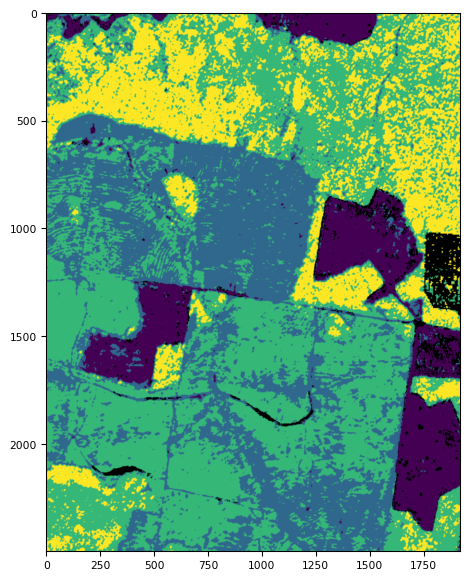

In [42]:
tiff.imshow((pr_0 + pr_1+pr_2+pr_3)*np.where(cl_0 + cl_1+cl_2+cl_3!=0, 1, 0))

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f750d681780>)

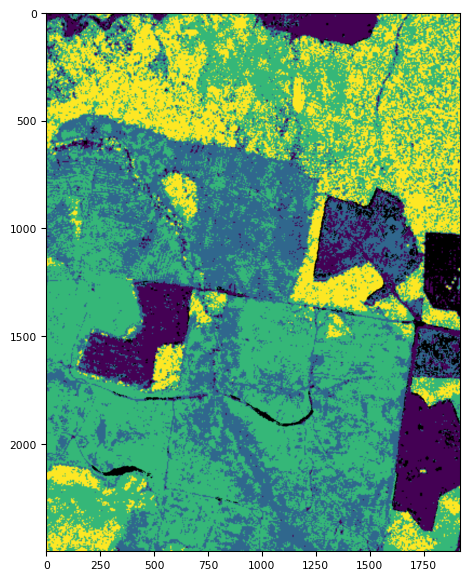

In [43]:
tiff.imshow((cl_0 + cl_1+cl_2+cl_3))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f108087b0b8>)

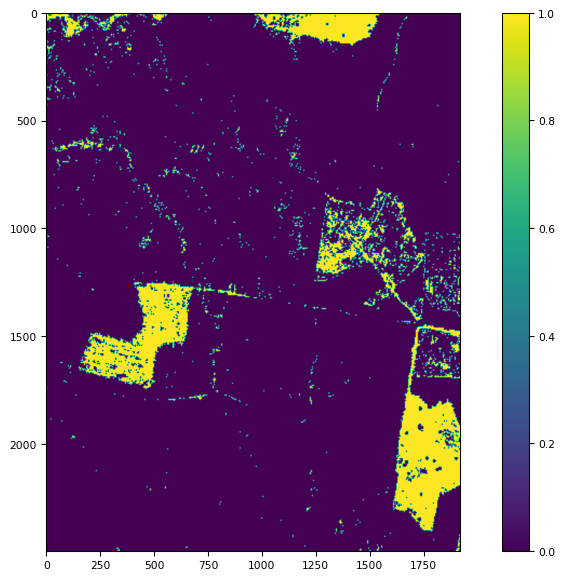

In [69]:
tiff.imshow(mask[:,:,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


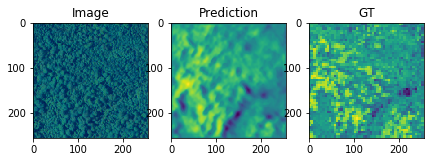

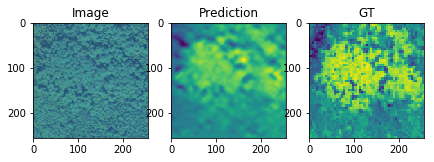

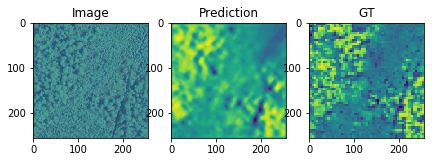

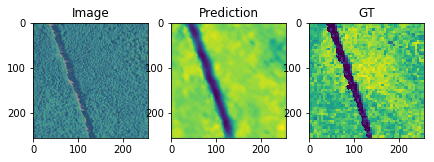

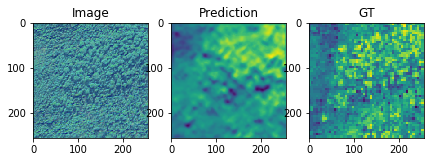

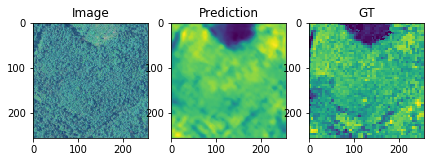

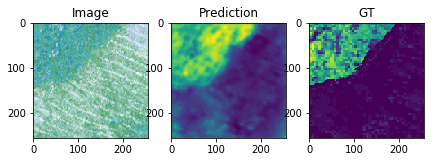

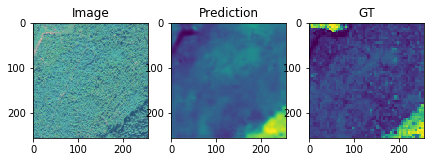

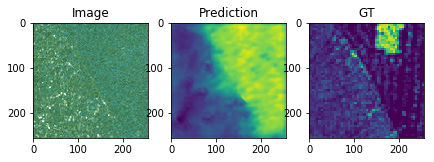

In [56]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

for num in range(1, 10):
    fig = plt.figure(figsize=(7, 7))
    
    a = fig.add_subplot(1, 3, 1)
    a.set_title('Image')
    imgplot = plt.imshow(img[num,:,:,:3])
    
    cl=0
    a = fig.add_subplot(1, 3, 2)
    a.set_title('Prediction')
    imgplot = plt.imshow(pred[num, :, :,0]) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 3, 3)
    a.set_title('GT')
    imgplot = plt.imshow(mask[num, :, :,0])

## Save prediction

In [255]:
val_img_list

['/home/user/data/krasnoborsk/world_view/0/6_3',
 '/home/user/data/krasnoborsk/world_view/0/4_2',
 '/home/user/data/krasnoborsk/world_view/0/2_2',
 '/home/user/data/krasnoborsk/world_view/0/1_1']

In [256]:
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    save_dist = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/' + img_path.split('/')[-1]
    save_pred(img_to_save=prediction[:,:,0]*generator.clip_value, save_dist=save_dist + '_pred.tif', \
          info_img=img_path + '_channel_0.tif', crs=4326)
    #tif2geojson(source_dir='../images/', tif_name='tmp', geojson_path='../images/tmp.geojson')

2045 1248 (2498, 1918)
2045 1248 (2498, 1918)
2045 1248 (2498, 1918)
2045 1248 (2498, 1918)


tmp = tiff.imread('../images/tmp.tif')

In [ ]:
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    save_pred(img_to_save=prediction[:,:,0]*generator.clip_value, save_dist='../images/tmp.tif', \
          info_img=img_path + '_channel_0.tif', crs=4326)
    tif2geojson(source_dir='../images/', tif_name='tmp', geojson_path='../images/tmp.geojson')
    break

## Experement with yandex image

In [165]:
def split_into_bands(input_tif, output_tif):
    new_img = output_tif + '0_channel_0.tif'
    ! gdal_translate -b 1 $input_tif $new_img
    new_img = output_tif + '0_channel_1.tif'
    ! gdal_translate -b 2 $input_tif $new_img
    new_img = output_tif + '0_channel_2.tif'
    ! gdal_translate -b 3 $input_tif $new_img

In [168]:
!gdalinfo '/home/user/data/krasnoborsk/yandex_val/0_channel_0.tif'

Driver: GTiff/GeoTIFF
Files: /home/user/data/krasnoborsk/yandex_val/0_channel_0.tif
Size is 3841, 4609
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (45.749816894531257,61.445167935251831)
Pixel Size = (0.000010728835790,-0.000005138232075)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.7498169,  61.4451679) ( 45d44'59.34"E, 61d26'42.60"N)
Lower Left  (  45.7498169,  61.4214858) ( 45d44'59.34"E, 61d25'17.35"N)
Upper Right (  45.7910264,  61.4451679) ( 45d47'27.69"E, 61d26'42.60"N)
Lower Right (  45.7910264,  61.4214858) ( 45d47'27.69"E, 61d25'17.35"N)
Center      (  45.7704216,  61.4333269) ( 45d46'13.52"E, 61d25'59.98"N)
Band 1 Block=3841x2 Type=Byte, ColorInterp=Red
  NoData Value

In [166]:
split_into_bands(input_tif='/home/user/data/krasnoborsk/yandex_val/orthophoto.tif', 
                 output_tif='/home/user/data/krasnoborsk/yandex_val/')

Input file size is 3841, 4609
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 3841, 4609
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 3841, 4609
0...10...20...30...40...50...60...70...80...90...100 - done.


In [169]:
train_img_list = ['/home/user/data/krasnoborsk/yandex_val/0']
val_img_list = ['/home/user/data/krasnoborsk/yandex_val/0']

In [231]:
batch_size=20 
num_channels=3

gdal_file_path = './'

generator = Generator(train_img_list, val_img_list, batch_size, num_channels, gdal_file_path=gdal_file_path)

generator.augm = False              # just geometric rotation is applied
generator.color_aug_prob = 1       # add color augm

generator.sharpen_flag = False     # flag to switch pansharpaning
generator.forest_mask = False       # add forest mask if it is provided
generator.arctic_dem = False
generator.arctic_stat = {'min':125, 'max':250}

generator.lidar_coef = 5           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 1    # target resolution both for height and imagery
generator.clip_value = 40.         # the greatest height value 

generator.classifier_mode = 'regression'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif']

generator.write_gdalinfo_file()

f
['/home/user/data/krasnoborsk/yandex_val/0_channel_0.tif', '/home/user/data/krasnoborsk/yandex_val/0_channel_1.tif', '/home/user/data/krasnoborsk/yandex_val/0_channel_2.tif', '/home/user/data/krasnoborsk/yandex_val/height_0.tif']
['/home/user/data/krasnoborsk/yandex_val/0_channel_0.tif', '/home/user/data/krasnoborsk/yandex_val/0_channel_1.tif', '/home/user/data/krasnoborsk/yandex_val/0_channel_2.tif', '/home/user/data/krasnoborsk/yandex_val/height_0.tif']


In [232]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), 
                  encoder_weights=None, activation='sigmoid')
loss =  rmse
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

model_name = 'regr_rgb_pan_wv' #_arctic
save_dir = '/home/user/data/example/data/Forestry_inventory/Height_model_paper/'

model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [241]:
prediction, full_mask = generator.pred_img(model=model, img_path=val_img_list[0])

In [244]:
generator.full_img = True
img, mask = generator.get_img_mask_array(imgpath=val_img_list[0])

In [239]:
round(np.mean(img[:,:,0]*255), 3), round(np.mean(img[:,:,1]*255), 3), round(np.mean(img[:,:,2]*255), 3)

(55.899, 71.519, 58.255)

Text(0.5,1,'Histogram Yandex')

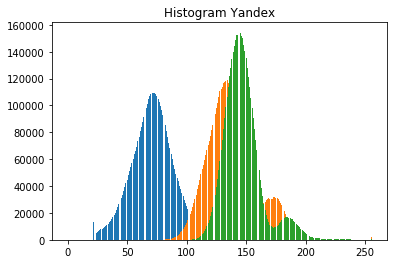

In [245]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

arr  = (img*255)[:,:,0].astype(int)#numpy.asarray(img)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)

arr  = (img*255)[:,:,1].astype(int)#numpy.asarray(img)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)

arr  = (img*255)[:,:,2].astype(int)#numpy.asarray(img)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)
plt.title("Histogram Yandex")

Text(0.5,1,'Histogram Yandex')

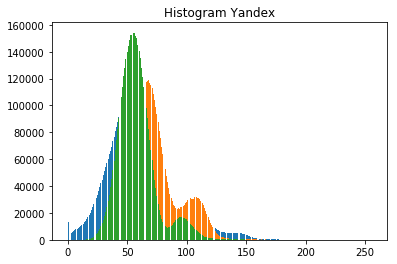

In [228]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

arr  = (img*255)[:,:,0].astype(int)#numpy.asarray(img)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)

arr  = (img*255)[:,:,1].astype(int)#numpy.asarray(img)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)

arr  = (img*255)[:,:,2].astype(int)#numpy.asarray(img)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)
plt.title("Histogram Yandex")

Text(0.5,1,'Histogram WV')

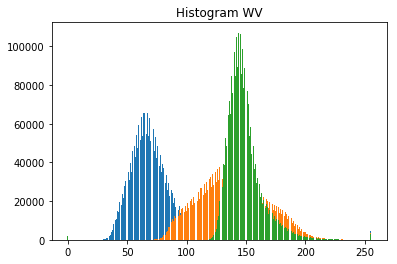

In [213]:

arr  = tiff.imread('/home/user/data/krasnoborsk/world_view/0/2_2_channel_0.tif').astype(int)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)

arr = tiff.imread('/home/user/data/krasnoborsk/world_view/0/2_2_channel_1.tif').astype(int)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)

arr = tiff.imread('/home/user/data/krasnoborsk/world_view/0/2_2_channel_2.tif').astype(int)
flat = arr.reshape(np.prod(arr.shape[:2]),-1)
data = np.bincount(np.sum(flat,1)//flat.shape[1],minlength=256) #bins

x = np.arange(256)
plt.bar(x, height=data)

plt.title("Histogram WV")

In [240]:
arr  = tiff.imread('/home/user/data/krasnoborsk/world_view/0/2_2_channel_0.tif').astype(int)
print(round(np.mean(arr), 3))
arr  = tiff.imread('/home/user/data/krasnoborsk/world_view/0/2_2_channel_1.tif').astype(int)
print(round(np.mean(arr), 3))
arr  = tiff.imread('/home/user/data/krasnoborsk/world_view/0/2_2_channel_2.tif').astype(int)
print(round(np.mean(arr), 3))

77.777
138.899
148.555


Text(0.5,1,'lidar')

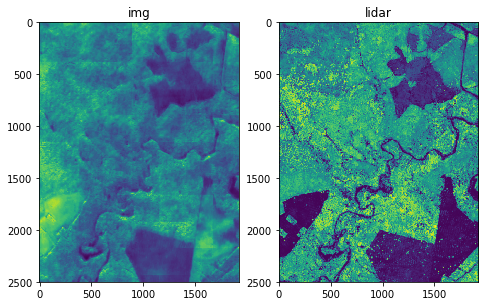

In [242]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((prediction[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow((full_mask[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('lidar')

Text(0.5,1,'lidar')

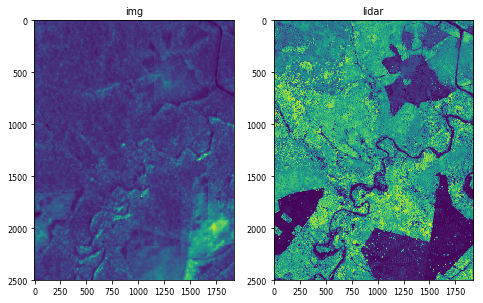

In [173]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((prediction[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow((full_mask[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('lidar')

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f0f5d12b400>)

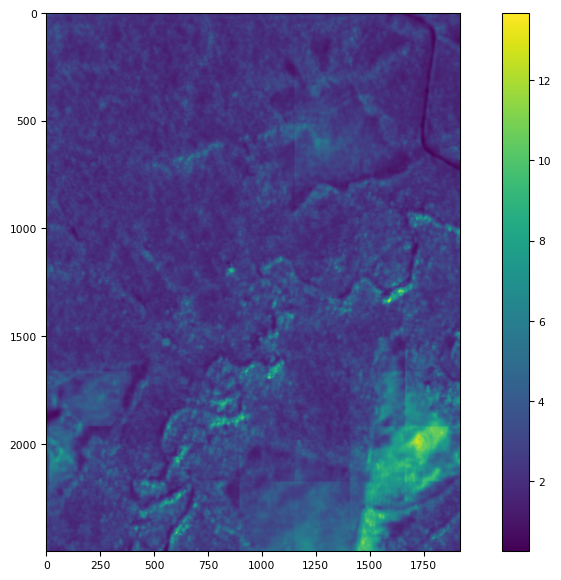

In [174]:
tiff.imshow(prediction*40)